# Proster Loans: An Exploration of Loss and Defaults
## by Summer Cook


> This document explores data from a Prosper Loans dataset, which includes data from 113937 loans from 2006 - 2014. 

In [62]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [63]:
df = pd.read_csv('prosperLoanData.csv')

In [64]:
#df.info()
df.duplicated().any()
print(df.shape)
print(df.dtypes)
print(df.head(10))

(113937, 81)
ListingKey                              object
ListingNumber                            int64
ListingCreationDate                     object
CreditGrade                             object
Term                                     int64
LoanStatus                              object
ClosedDate                              object
BorrowerAPR                            float64
BorrowerRate                           float64
LenderYield                            float64
EstimatedEffectiveYield                float64
EstimatedLoss                          float64
EstimatedReturn                        float64
ProsperRating (numeric)                float64
ProsperRating (Alpha)                   object
ProsperScore                           float64
ListingCategory (numeric)                int64
BorrowerState                           object
Occupation                              object
EmploymentStatus                        object
EmploymentStatusDuration               float64


### What is the structure of your dataset?

> The dataset has a very large number of variables with 81 columns. It has 113937 rows. There are both numeric and categorical variables. There is one row for each loan, which includes variables that describe the loan such as interest rates and when the loan started as well as the borrower of the loan such as credit scores and income. 

### What is/are the main feature(s) of interest in your dataset?

> I am interested in poorly performing loans. Loans with a Loan Status of "Default" or "Chargedoff" and LP Net Principal Loss are the variables that I will explore. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Variables I expect to be explanatory are: Credit Scores, Income (Reported Monthly Income and Income Range), Debt to Income Ratio, Prosper Rating, Borrower Rate (interest rate), Listing Category (what the loan is used for), Homeownership and Estimated Loss.

## Preliminary Wrangling


In [65]:
# Spaces are removed from the column names
df.columns = df.columns.str.replace(' ', '')
df.ListingCreationDate = pd.to_datetime(df.ListingCreationDate)

In [66]:
# I already know that I will be interested in the origin date so the data type is changed. 
df.LoanOriginationDate = pd.to_datetime(df.LoanOriginationDate )

In [67]:


# ratings and Income ranges are ordered. 
ordinal_var_dict = {'ProsperRating(Alpha)': ['N/A', 'HR', 'E', 'D', 'C', 'B', 'A', 'AA'], 
                    'IncomeRange': ['Not displayed', '$0','$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

In [68]:
df['CreditScoreRangeUpper'].value_counts().sort_values()

379.0        1
439.0        5
899.0       27
459.0       36
19.0       133
479.0      141
879.0      212
499.0      346
519.0      554
859.0      567
599.0     1125
579.0     1357
839.0     1409
559.0     1474
539.0     1593
819.0     2644
619.0     3602
639.0     4172
799.0     4624
779.0     6606
759.0     9267
659.0    12199
739.0    12923
719.0    15471
679.0    16366
699.0    16492
Name: CreditScoreRangeUpper, dtype: int64

In [69]:
# I would like the listing category name to be shown in the graphs, so a new column is made with the names rather than the corresponding numbers

df['ListingCategory'] =  df['ListingCategory(numeric)'].replace({0:'Not Available', 1:'Debt Consolidation', 2:'Home Improvement', 3:'Business', 4:'Personal Loan', 5:'Student Use', 6:'Auto', 
              7:'Other', 8:'Baby&Adoption', 9:'Boat', 10:'Cosmetic Procedure', 11:'Engagement Ring', 12:'Green Loans', 13:'Household Expenses', 
              14:'Large Purchases', 15:'Medical/Dental', 16:'Motorcycle', 17:'RV', 18:'Taxes', 19:'Vacation', 20:'Wedding Loans'})


## Univariate Exploration

### We will start by looking at the variables of interest.  "LoanCurrentDaysDelinquent" and "LoanStatus" are interesting measures of poor performance. 

####  Loan Status
The first graph shows the distribution of the loan status variable

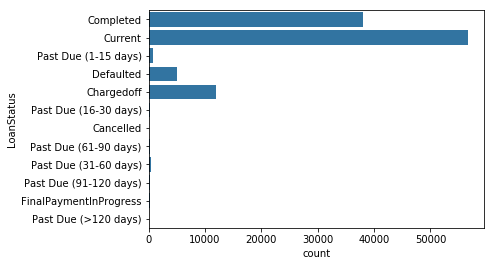

In [70]:

# Since we are interest in poorly performing loans we will look at loan status.  
default_color = sb.color_palette()[0]
sb.countplot(data = df, y = 'LoanStatus', color = default_color)


There are not a high percentage of loans that are defaulted, but there are enough that it's worth trying to find some explaination. There are also a significant amount of chargedoff loans. According to Wikipedia, "A charge-off or chargeoff is the declaration by a creditor (usually a credit card account) that an amount of debt is unlikely to be collected. This occurs when a consumer becomes severely delinquent on a debt. Traditionally, creditors will make this declaration at the point of six months without payment." The frequency of chargedoff loans is almost twice as high as defaulted loans and definitely worth looking at. 

####  Net Principal Loss

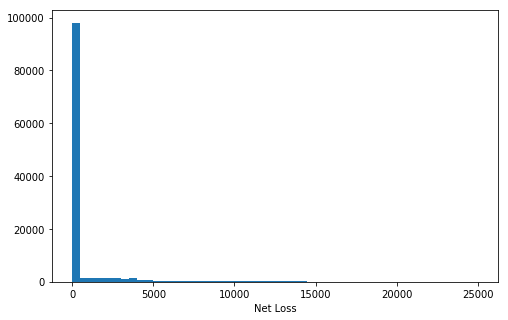

25000.0

In [71]:
#LP_NetPrincipalLoss
binsize = 500
bins = np.arange(0, df['LP_NetPrincipalLoss'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'LP_NetPrincipalLoss', bins = bins)
plt.xlabel('Net Loss')
plt.show()
#LoanStatus
df.LP_NetPrincipalLoss.max()


With a logarithmic transformation Net Principal Loss shows a normal distribution

([<matplotlib.axis.XTick at 0x1b96d773630>,
 <a list of 9 Text xticklabel objects>)

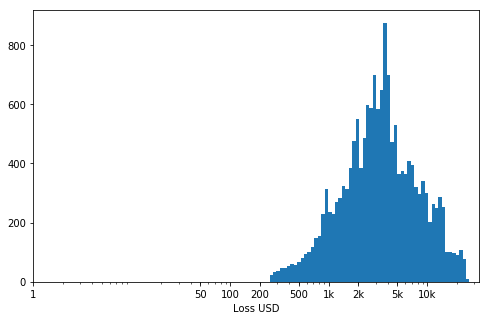

In [72]:
log_binsize = 0.035
bins = 10 ** np.arange(2.4, np.log10(df['LP_NetPrincipalLoss'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'LP_NetPrincipalLoss', bins = bins)
plt.xlabel('Loss USD')
plt.xscale('log')
plt.xticks([1, 50, 100, 200, 500, 1000, 2000, 5000, 10000], ['1','50', '100', '200', '500', '1k', '2k', '5k', '10k'])



With a logarithmic transformation, the Net Principal Loss shows a normal distribution. 

### Explanatory variables
- I will look for interactions between or variables of interest and other variables that might help us better understand poor loan performance. Below, we will become familiar with some of these variables. 

#### Loan Origination Date
Because I am interested in poor loan performance, the age of the loan and whether it is completed or not may be a confounding factor. I will look at the distribution of the loan Origin date

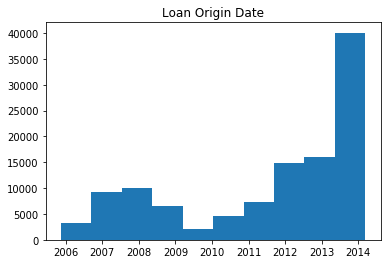

In [73]:
plt.hist(data = df, x ='LoanOriginationDate')
plt.title('Loan Origin Date')
plt.show()

This graph reveals a challenge for out investigation. There is a large spike in Loans during the last years for which there are data
That means that a large part of the loans are so new that they would not have had time to show how they will perform. This can be dealt with by using the data from loans that have been completed.

In [74]:
# A new data frame is made from loans that are completed
df_completed = df.query('LoanStatus =="Completed" | LoanStatus == "ChargedOff" | LoanStatus == "Defaulted"')
df_current = df[~df.index.isin(df_completed.index)]
# a boolean column is also created for loans that are either charged off or defaulted
df_completed['Defaulted/ChargedOff']= (df_completed.LoanStatus == 'ChargedOff') | (df_completed.LoanStatus == 'Defaulted')


C:\Users\Summer\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


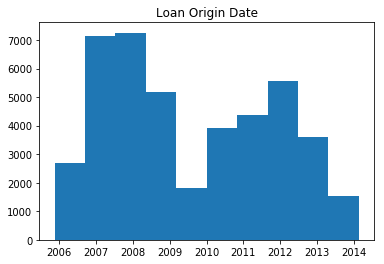

In [75]:
#completed loans
plt.hist(data = df_completed, x ='LoanOriginationDate')
plt.title('Loan Origin Date')
plt.show()

We now have a smaller data set with 42994 entries. This data set is used for the remaining analysis. Later investigation will reveal that the bimodal shape in this distribution is due a total gap in data between 2009-2010.

In [76]:
df_completed.shape

(43092, 83)

#### Prosper Principal Outstanding (Previous debt in Prosper loans)
The second explanatory variable is Prosper Principal Outstanding, which is the borrower's outstanding debt in other Prosper loans at the outset of each particular loan. This will help us find out whether previous debt is related to loan performance

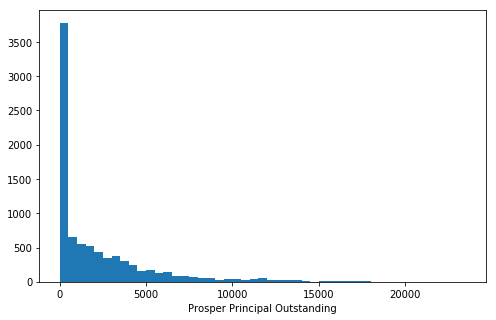

23450.95

In [77]:
# Distribution of Outstanding debt in Prosper loans
binsize = 500
bins = np.arange(0, df['ProsperPrincipalOutstanding'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df_completed, x = 'ProsperPrincipalOutstanding', bins = bins)
plt.xlabel('Prosper Principal Outstanding')
plt.show()
#LoanStatus
df.ProsperPrincipalOutstanding.max()

This graph is scewed to the right and looks like this may have a lognormal distribution.
Below is the data with a transformation. 

Text(0.5, 0, 'Prosper Principal Outstanding')

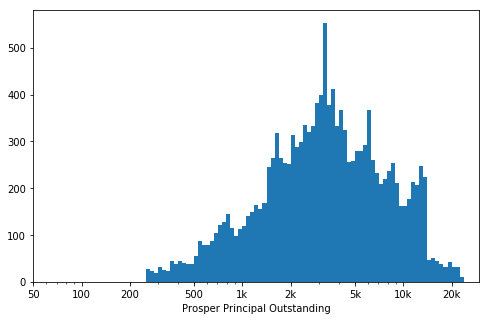

In [78]:
#outstanding= df.query('ProsperPrincipalOutstanding != 0')
log_binsize = 0.025
bins = 10 ** np.arange(2.4, np.log10(df_completed['ProsperPrincipalOutstanding'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'ProsperPrincipalOutstanding', bins = bins)
plt.xscale('log')
plt.xticks([50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000], ['50', '100', '200', '500', '1k', '2k', '5k', '10k', '20k'])
plt.xlabel('Prosper Principal Outstanding')



The Principal Outstanding also shows a normal distribution with a logarithmic transformation. 

#### Borrower Rates (Interest Rates)

(array([1.300e+01, 1.100e+01, 1.000e+00, 9.000e+00, 7.000e+01, 3.260e+02,
        6.100e+02, 1.373e+03, 1.940e+03, 1.998e+03, 2.199e+03, 1.618e+03,
        1.657e+03, 1.864e+03, 2.318e+03, 2.206e+03, 1.547e+03, 1.682e+03,
        1.596e+03, 1.484e+03, 1.706e+03, 1.295e+03, 1.075e+03, 1.326e+03,
        1.373e+03, 1.539e+03, 1.522e+03, 9.960e+02, 8.070e+02, 1.545e+03,
        6.220e+02, 2.507e+03, 3.040e+02, 2.450e+02, 1.669e+03, 2.000e+01,
        1.200e+01, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
 <a list of 50 Patch objects

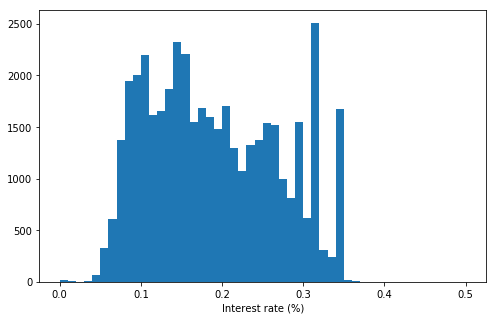

In [79]:
# Distribution of interest rates
binsize = 0.01
bins = np.arange(0, df['BorrowerRate'].max()+binsize, binsize)
plt.figure(figsize=[8, 5])
plt.xlabel('Interest rate (%)')
plt.hist(data = df_completed, x = 'BorrowerRate', bins = bins)

Interest rates show a fairy normal distribution with an exception of a spike around 0.3%. There are some outliers so we will narrow our view of the data by adjusting the limits. 

(array([  69.,  257.,  308.,  302.,  763.,  610., 1175.,  765., 1171.,
         827., 1347.,  852.,  930.,  688.,  872.,  785.,  768., 1096.,
        1373.,  945., 1240.,  966.,  837.,  710.,  758.,  924.,  886.,
         710.,  786.,  698., 1179.,  527.,  710.,  585.,  612.,  463.,
         715.,  611.,  590.,  783.,  625.,  914.,  736.,  786.,  536.,
         460.,  324.,  483., 1097.,  448.,  273.,  349.,  569., 1938.,
         221.,   83.,  188.,   57.,  328.,  112., 1230.]),
 array([0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
        0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135,
        0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 ,
        0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225,
        0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 ,
        0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315,
        0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355]),
 <a list of 61 Patch ob

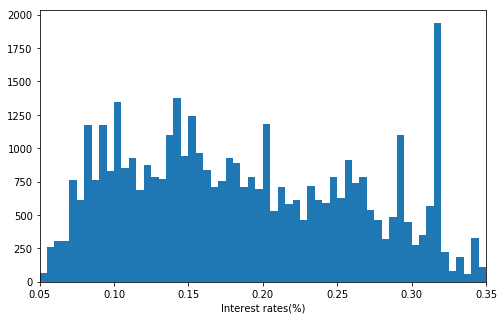

In [80]:
# A closer look at interest rates
plt.figure(figsize=[8, 5])
bins = np.arange(0.05, 0.36, 0.005)
plt.xlim([0.05,0.35])
plt.xlabel('Interest rates(%)')
plt.hist(data = df_completed, x = 'BorrowerRate', bins = bins)

The spike at 0.35% in interest rates is even more pronounced with this view. 

#### Credit Scores

Credit scores may also provide some insight. I chose to include the upper range of Credit Score. (Upper and Lower credit scores are almost perfectly correlated.)

(array([9.800e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 2.200e+01, 1.050e+02,
        2.540e+02, 4.050e+02, 9.530e+02, 1.004e+03, 9.300e+02, 7.890e+02,
        2.272e+03, 2.526e+03, 4.691e+03, 4.618e+03, 4.758e+03, 4.220e+03,
        4.054e+03, 3.344e+03, 2.788e+03, 2.054e+03, 1.294e+03, 8.100e+02,
        3.680e+02, 1.900e+02]),
 array([ 19.,  39.,  59.,  79.,  99., 119., 139., 159., 179., 199., 219.,
        239., 259., 279., 299., 319., 339., 359., 379., 399., 419., 439.,
        459., 479., 499., 519., 539., 559., 579., 599., 619., 639., 659.,
        679., 699., 719., 739., 759., 779., 799., 819., 839., 859., 879.,
        899.]),
 <a list of 44 Patch objects>)

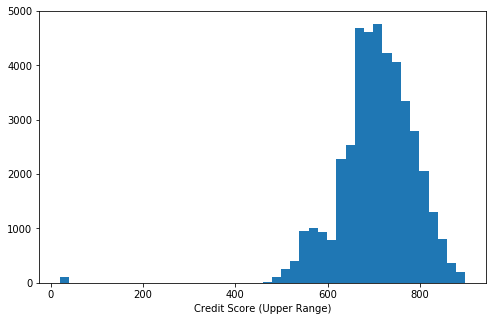

In [81]:
# Distribution of credit scores
binsize = 20
bins = np.arange(df_completed['CreditScoreRangeUpper'].min(), df_completed['CreditScoreRangeUpper'].max()+binsize, binsize)
plt.figure(figsize=[8, 5])
plt.xlabel('Credit Score (Upper Range)')

plt.hist(data = df_completed, x = 'CreditScoreRangeUpper', bins = bins)

The distribution of credit scores is approximately normal but there appears to be some outliers. There are 98 entries the 19 in credit score. These seem unusual and I will remove them from the dataframe. 


In [82]:
# examine outliers
low_outliers = (df_completed['CreditScoreRangeUpper'] < 20)


print(low_outliers.sum())
print(df_completed.loc[low_outliers][['CreditScoreRangeUpper','LoanOriginationDate']])
print(df_completed.loc[low_outliers])

98
        CreditScoreRangeUpper LoanOriginationDate
794                      19.0          2007-02-22
912                      19.0          2006-11-20
4371                     19.0          2006-08-28
4430                     19.0          2006-10-03
5684                     19.0          2006-12-29
9048                     19.0          2006-12-18
13395                    19.0          2006-05-02
13686                    19.0          2006-11-28
13938                    19.0          2006-11-21
15093                    19.0          2006-09-11
18774                    19.0          2006-10-03
18836                    19.0          2007-01-16
19737                    19.0          2006-09-27
20736                    19.0          2006-12-13
21047                    19.0          2006-11-28
21397                    19.0          2007-01-09
22399                    19.0          2006-07-25
24999                    19.0          2006-06-20
25363                    19.0          2006-09-

There are 98 loans with borrowers with a credit score of 19. I do not have an explanation for why these would be invalid values. Instead of removing them, I will set the limits in future graphs to focus on the data points within the normal distribution. 

(400, 900)

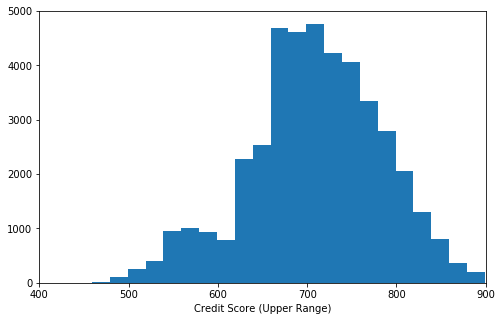

In [83]:
# Distribution of Credit Scores without outliers
binsize = 20
bins = np.arange(df_completed['CreditScoreRangeUpper'].min(), df_completed['CreditScoreRangeUpper'].max()+binsize, binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = df_completed, x = 'CreditScoreRangeUpper', bins = bins)
plt.xlabel('Credit Score (Upper Range)')
plt.xlim([400,900])


#### Below, three bar plots were created from categorical variables below, including:
- ProsperRating(Alpha)
- IncomeRange
- IsBorrowerHomeowner



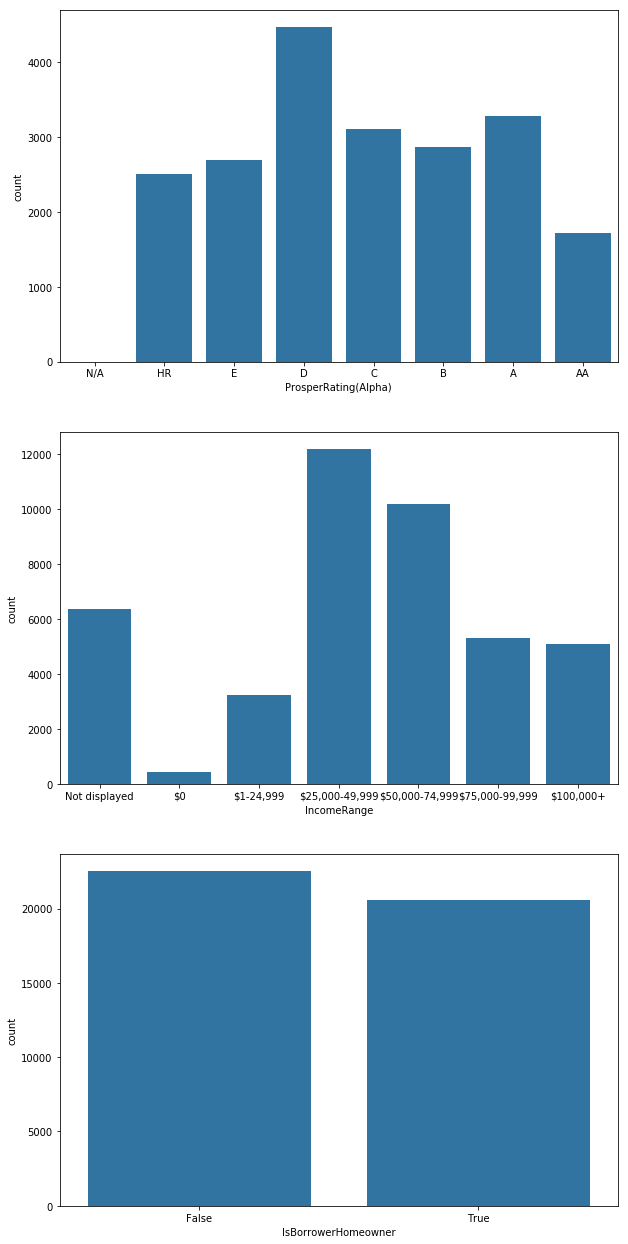

In [84]:
fig, ax = plt.subplots(nrows=3, figsize = [10,22])
default_color = sb.color_palette()[0]
sb.countplot(data = df_completed, x = 'ProsperRating(Alpha)', color = default_color,  ax = ax[0])
sb.countplot(data = df_completed, x = 'IncomeRange', color = default_color,  ax = ax[1])
sb.countplot(data = df_completed, x = 'IsBorrowerHomeowner', color = default_color,  ax = ax[2])

- The prosper rating data shows a normal distribution. 
- Most loans were given to borrowers in the middle ranges of income levels: 25-50K and 50K to 75K. 
- There are about equal amounts of homeowners vs non-homeowners. 

These distributions will need to be taken into account when investigating relationships that may explain poor performance in the bivariate and multivariate exploration. 

#### Listing Category
Listing Category, or what the loan will be used for, will be examined next. 

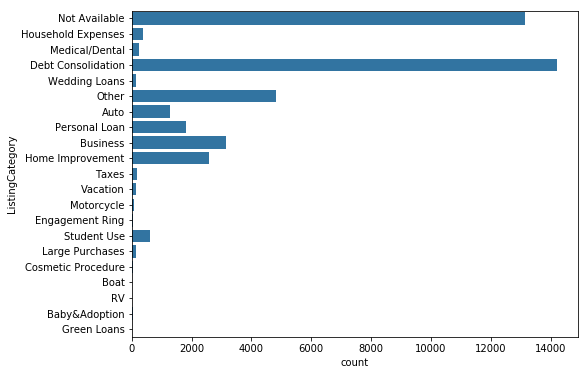

In [85]:
categories =['Not Available', 'Debt Consolidation', 'Home Improvement', 'Business', 'Personal Loan', 'Student Use', 'Auto', 'Other', 'Baby&Adoption', 'Boat', 'Cosmetic Procedure', 'Engagement Ring', 'Green Loans', 'Household Expenses', 'Large Purchases', 'Medical/Dental', 'Motorcycle', 'RV', 'Taxes', 'Vacation', 'Wedding Loans']

df['ListingCategory'] = df['ListingCategory'].astype('category')
plt.figure(figsize=[8,6])

sb.countplot(data = df_completed, y = 'ListingCategory', color = default_color)


It turns out that the loans are used for all sorts of interesting things. Debt consolidation has the highest frequency, but there are many other things such as home improvement and Wedding Loans. There are also many loans where data for this variable is missing. 

#### Debt to Income Ratio

(array([2.076e+03, 4.638e+03, 7.645e+03, 5.762e+03, 5.623e+03, 4.989e+03,
        3.062e+03, 1.767e+03, 1.349e+03, 9.230e+02, 5.790e+02, 4.430e+02,
        1.960e+02, 2.080e+02, 1.030e+02, 8.700e+01, 6.800e+01, 4.900e+01,
        4.200e+01, 3.500e+01, 2.500e+01, 2.300e+01, 1.200e+01, 1.600e+01,
        1.100e+01, 1.100e+01, 8.000e+00, 7.000e+00, 8.000e+00, 8.000e+00,
        6.000e+00, 1.000e+01, 5.000e+00, 3.000e+00, 4.000e+00, 3.000e+00,
        4.000e+00, 6.000e+00, 6.000e+00, 6.000e+00, 1.000e+00, 4.000e+00,
        3.000e+00, 3.000e+00, 5.000e+00, 5.000e+00, 1.000e+00, 4.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 1.000e+0

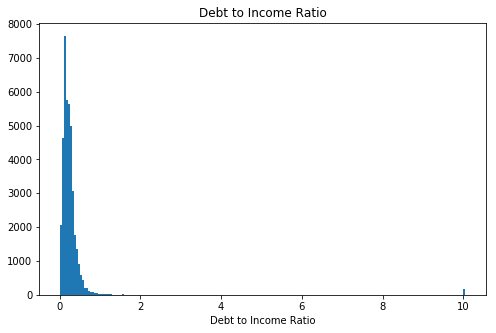

In [86]:
# 'DebtToIncomeRatio']
binsize = 0.05
bins = np.arange(df_completed['DebtToIncomeRatio'].min(), df_completed['DebtToIncomeRatio'].max()+binsize, binsize)
plt.figure(figsize=[8, 5])
plt.xlabel('Debt to Income Ratio')
plt.title('Debt to Income Ratio')

plt.hist(data = df_completed, x = 'DebtToIncomeRatio',  bins = bins)

It appears that there are strong outliers.

In [87]:
# values over 1 are counted
(df_completed.DebtToIncomeRatio > 2).value_counts()

False    42815
True       277
Name: DebtToIncomeRatio, dtype: int64

I do not have reason to believe that these are invalid values. The google sheets documentent provided explains that the values have already been cut off at 10.01 so I will keep the data set as it is as there were borrowers with over %1000 of their income in debt.

(array([2.076e+03, 4.638e+03, 7.645e+03, 5.762e+03, 5.623e+03, 4.989e+03,
        3.062e+03, 1.767e+03, 1.349e+03, 9.230e+02, 5.790e+02, 4.430e+02,
        1.960e+02, 2.080e+02, 1.030e+02, 8.700e+01, 6.800e+01, 4.900e+01,
        4.200e+01, 3.500e+01, 2.500e+01, 2.300e+01, 1.200e+01, 1.600e+01,
        1.100e+01, 1.100e+01, 8.000e+00, 7.000e+00, 8.000e+00, 8.000e+00,
        6.000e+00, 1.000e+01, 5.000e+00, 3.000e+00, 4.000e+00, 3.000e+00,
        4.000e+00, 6.000e+00, 6.000e+00, 6.000e+00, 1.000e+00, 4.000e+00,
        3.000e+00, 3.000e+00, 5.000e+00, 5.000e+00, 1.000e+00, 4.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 1.000e+0

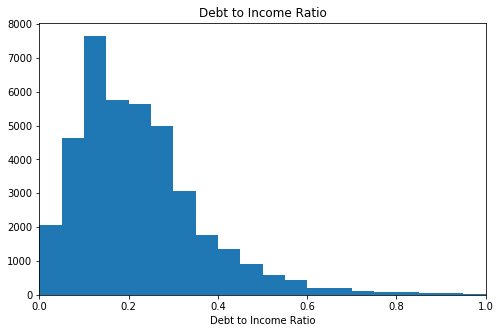

In [88]:
plt.figure(figsize=[8, 5])
plt.xlim([0,1])

plt.xlabel('Debt to Income Ratio')
plt.title('Debt to Income Ratio')

plt.hist(data = df_completed, x = 'DebtToIncomeRatio',  bins = bins)

#### Stated Monthly Income

(array([1.773e+03, 2.817e+03, 6.921e+03, 7.248e+03, 6.393e+03, 5.273e+03,
        3.755e+03, 2.649e+03, 1.789e+03, 1.038e+03, 1.040e+03, 4.810e+02,
        4.820e+02, 2.650e+02, 1.730e+02, 2.000e+02, 2.010e+02, 7.800e+01,
        6.900e+01, 3.700e+01, 1.040e+02, 1.700e+01, 3.200e+01, 2.100e+01,
        3.000e+00, 5.100e+01, 8.000e+00, 1.800e+01, 1.000e+01, 1.800e+01,
        1.200e+01, 4.000e+00, 5.000e+00, 2.200e+01, 1.000e+00, 6.000e+00,
        2.000e+00, 8.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.400e+01,
        0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 1.000e+0

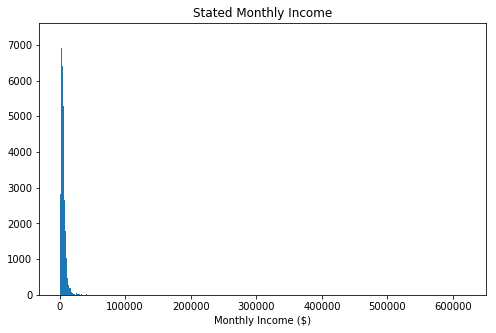

In [89]:
binsize = 1000
bins = np.arange(0, df_completed['StatedMonthlyIncome'].max()+binsize, binsize)
plt.figure(figsize=[8, 5])
plt.xlabel('Monthly Income ($)')
plt.title('Stated Monthly Income')

plt.hist(data = df_completed, x = 'StatedMonthlyIncome', bins = bins)


It is again clear that there are outliers.

In [90]:
low_outliers = (df_completed['StatedMonthlyIncome'] > 100000)


print(low_outliers.sum())
print(df_completed.loc[low_outliers][['StatedMonthlyIncome','IncomeRange']])
print(df_completed.loc[low_outliers])

8
        StatedMonthlyIncome    IncomeRange
8066          416666.666667      $100,000+
17411         483333.333333      $100,000+
35218         108333.333333      $100,000+
53014         618547.833333      $100,000+
56867         185081.750000      $100,000+
63925         140416.666667  Not displayed
83697         185081.750000  Not displayed
111265        108750.000000      $100,000+
                     ListingKey  ListingNumber     ListingCreationDate  \
8066    37043512916744588463B5A         500651 2011-04-02 13:58:32.227   
17411   873B351262140884511D81C         501462 2011-04-08 21:58:21.847   
35218   CB0C3485937995411C24C46         461028 2010-06-01 18:34:31.423   
53014   F5D13567265432980C80C7D         694401 2013-01-04 20:02:24.207   
56867   B7FC33861182547660E2E00         120075 2007-04-06 18:12:51.793   
63925   8E713364810500612B4B731          25554 2006-07-19 19:09:12.950   
83697   1FCB33802527950304EB984          93861 2007-02-05 18:37:03.927   
111265  82503581768

Again, I do not have reason to believe that these values are invalid so I will leave the data as it is. 

(0, 50000)

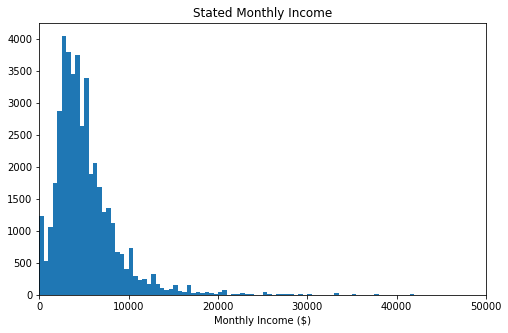

In [91]:
binsize = 500
bins = np.arange(0, df_completed['StatedMonthlyIncome'].max()+binsize, binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = df_completed, x = 'StatedMonthlyIncome', bins = bins)
plt.xlabel('Monthly Income ($)')
plt.title('Stated Monthly Income')
plt.xlim([0,50000])


A close-up view of the data shows a distribution skewed to the right. 

In [92]:
# the final number of observation is 43092
df_completed.shape

(43092, 83)

In [93]:
df_completed.to_csv('prosper_completed.csv', index = False)

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> I found that there are quite a few loans that have either been defaulted or charged off. These will be interesting to explore. Net Principal Loss and Prosper Loans Outstanding show a normal distribution when tranformed logarithmically. It was interesting that most of the borrowers have low to middle incomes between 25 and 75 thousand annually. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Many of the interesting variables have normal distributions and the data is quite tidy. I removed some of the outliers in the Credit Scores column. I also eliminated the debt to income ratios that were above 1, as they are clearly an error. I also decided to make the data set substantially smaller. This was particulary important because there where so many loans that are under a year old at the time the data was pulled and may not have had time to show how they will perform. 

## Bivariate Exploration

First, we will find all of the relationships between the numeric variables. A sample of the data points is taken because of the large number of data points.

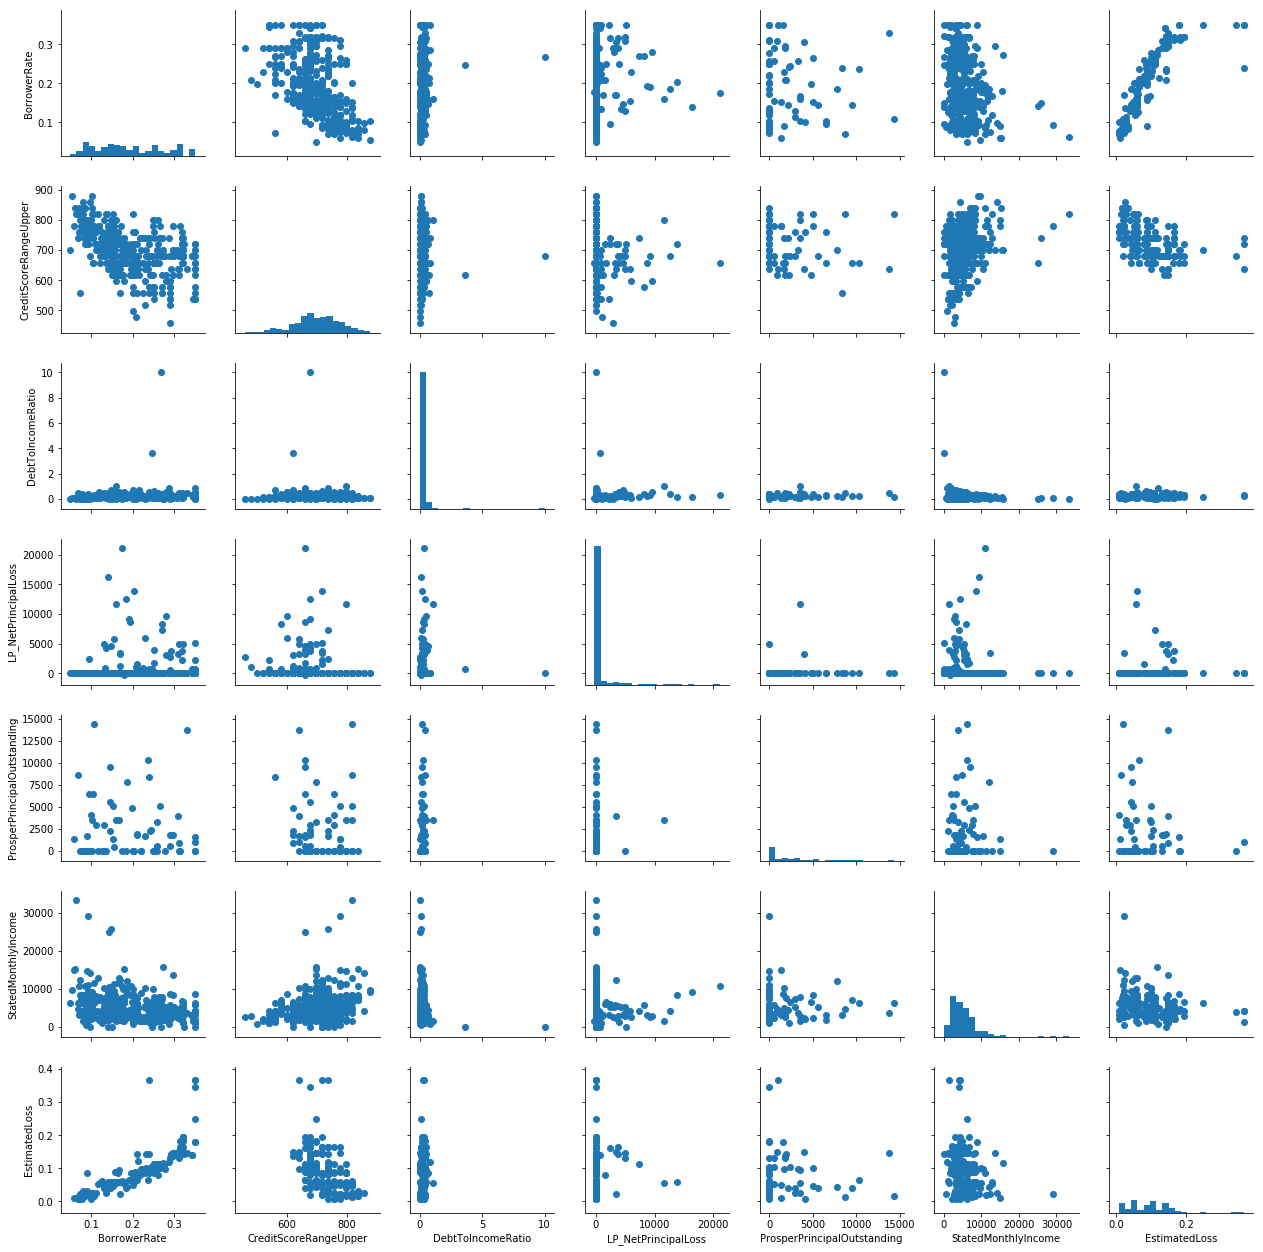

In [94]:
numeric_vars = ['BorrowerRate','CreditScoreRangeUpper', 'DebtToIncomeRatio', 'LP_NetPrincipalLoss', 'ProsperPrincipalOutstanding',
               'StatedMonthlyIncome', 'EstimatedLoss']

samples = np.random.choice(df_completed.shape[0], 1000, replace = False)
df_samp = df_completed.loc[samples,:]

g = sb.PairGrid(data = df_samp, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 20)
g.map_offdiag(plt.scatter)


The main numerical variable of interest, LP Net Principal Loss, does not appear to have any strong relationships with the other variables. 
The plots above that appear to have linear or non-random relationships are variables that describe the loan or borrower at the outset of the loan. For example, borrower rates (interest rates) are correlated with estimated loss and credit scores. 

This can be seen more clearly in the correlation map below. 

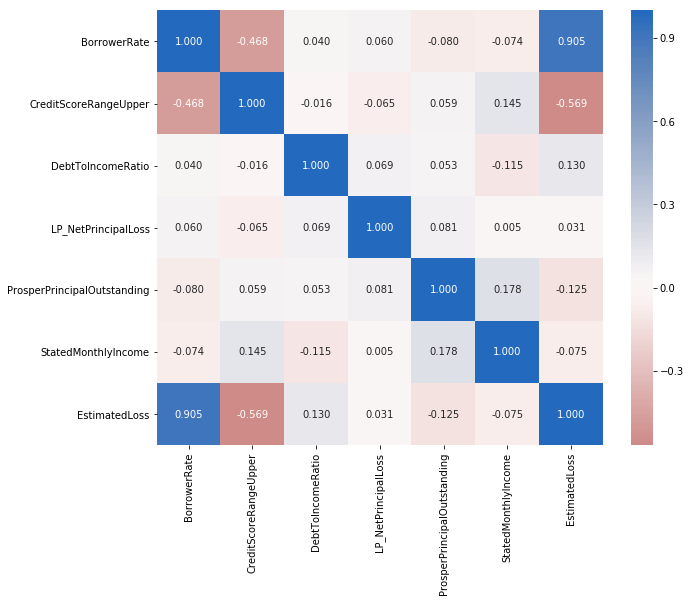

In [95]:
plt.figure(figsize = [10, 8])
sb.heatmap(df_completed[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

#### Net Principal Loss and explanitory numeric variables

The following shows an example of the bank's effort to limit loss.
It shows the relationship between previous debt and Net Principal loss. The correlation coefficient is only 0.081, -0.065 and 0.031 respectively. 

Text(0.5, 1.0, 'Estimated Loss')

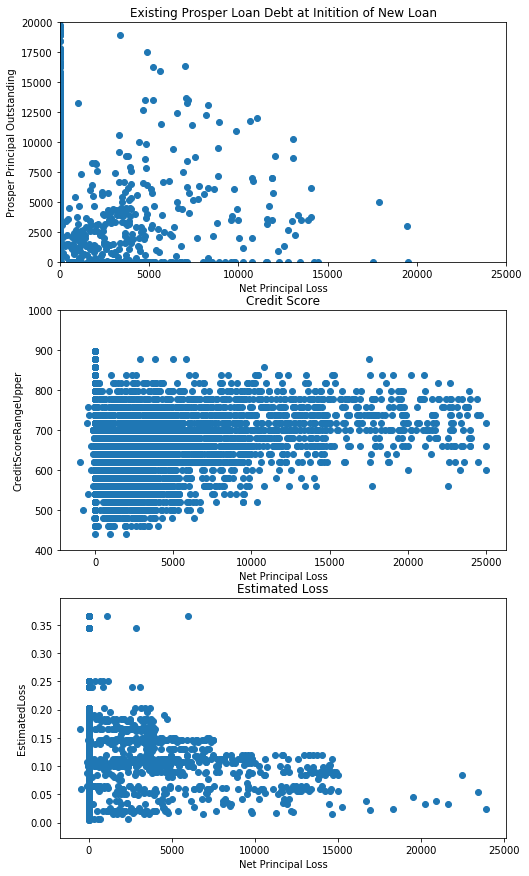

In [96]:


plt.figure(figsize = [8, 15])

plt.subplot(3, 1, 1)
plt.scatter(data = df_completed, y = 'ProsperPrincipalOutstanding', x = 'LP_NetPrincipalLoss')
plt.xlim([1,25000])
plt.ylim([1,20000])
plt.xlabel('Net Principal Loss')
plt.ylabel('Prosper Principal Outstanding')
plt.title('Existing Prosper Loan Debt at Initition of New Loan')


plt.subplot(3,1,2)
plt.scatter(data = df_completed, y = 'CreditScoreRangeUpper', x = 'LP_NetPrincipalLoss')
plt.xlabel('Net Principal Loss')
plt.ylabel('CreditScoreRangeUpper')
plt.ylim([400,1000])
plt.title('Credit Score')

plt.subplot(3, 1, 3)
plt.scatter(data = df_completed, y = 'EstimatedLoss', x = 'LP_NetPrincipalLoss')
plt.xlabel('Net Principal Loss')
plt.ylabel('EstimatedLoss')
plt.title('Estimated Loss')


Observe the right half of the graphs above. This half shows loans were high amounts were lost. They are all populated by loans with variables associated with lower risk. 

- Graph 1:On the first graph, there is a clear diagnonal line that shows that the bank has conditioned the new loans on the borrower's previous Prosper debt in order to avoid loss. Borrowers that have high debt were either not allowed to get large loans or were required to pay enough interest to dissuade them. 

- Graph 2: In the second graph, low credit scores are not present in the right side of the graph. 

- Graph 3: In the third graph, only loans with the lowest estimated loss can be found among the loans with over USD15000 in loss. In fact, it looks like there is a step-wise decline from left to right, as if the size of loans has been capped at discrete levels of estimated loss: 0.25 seems to have an approximate cap at somewhere below USD 5000, 0.20 at USD 5000, 0.15 around USD 7000, and 0.10 at USD 15000. 

#### Categorical variable (Prosper Rating) and numeric variables
The following will compare Prosper Rating with Estimated Loss and Interest Rates (Borrower Rate). On the right, we can see that the bank sets interest rates according to its perceived risk. Measures like this help prevent Estimated Loss from becoming highly correlated with actual loss. 

Text(0.5, 1.0, 'Prosper Rating and Interest Rates')

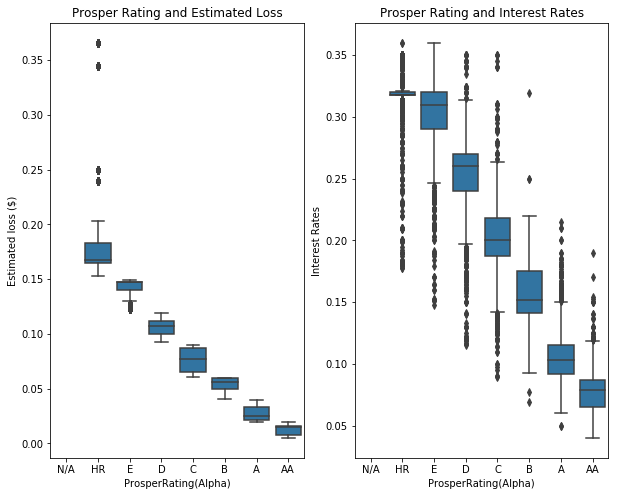

In [97]:
plt.figure(figsize = [10, 8])
base_color = sb.color_palette()[0]

# left plot: box plot
plt.subplot(1, 2, 1)
ax1 = sb.boxplot(data = df_completed , x= 'ProsperRating(Alpha)', y ='EstimatedLoss',color = base_color)
plt.ylabel('Estimated loss ($)')
plt.title('Prosper Rating and Estimated Loss')

# # right plot: box plot
plt.subplot(1, 2, 2)
sb.boxplot(data = df_completed, x = 'ProsperRating(Alpha)', y = 'BorrowerRate', color = base_color)
plt.ylabel('Interest Rates')
plt.title('Prosper Rating and Interest Rates')


#### Categorical variables: 4 categorical variables vs. Defaults and Charged Off loans
Next we will compare the categorical variables to Charged Off and Defaulted loans

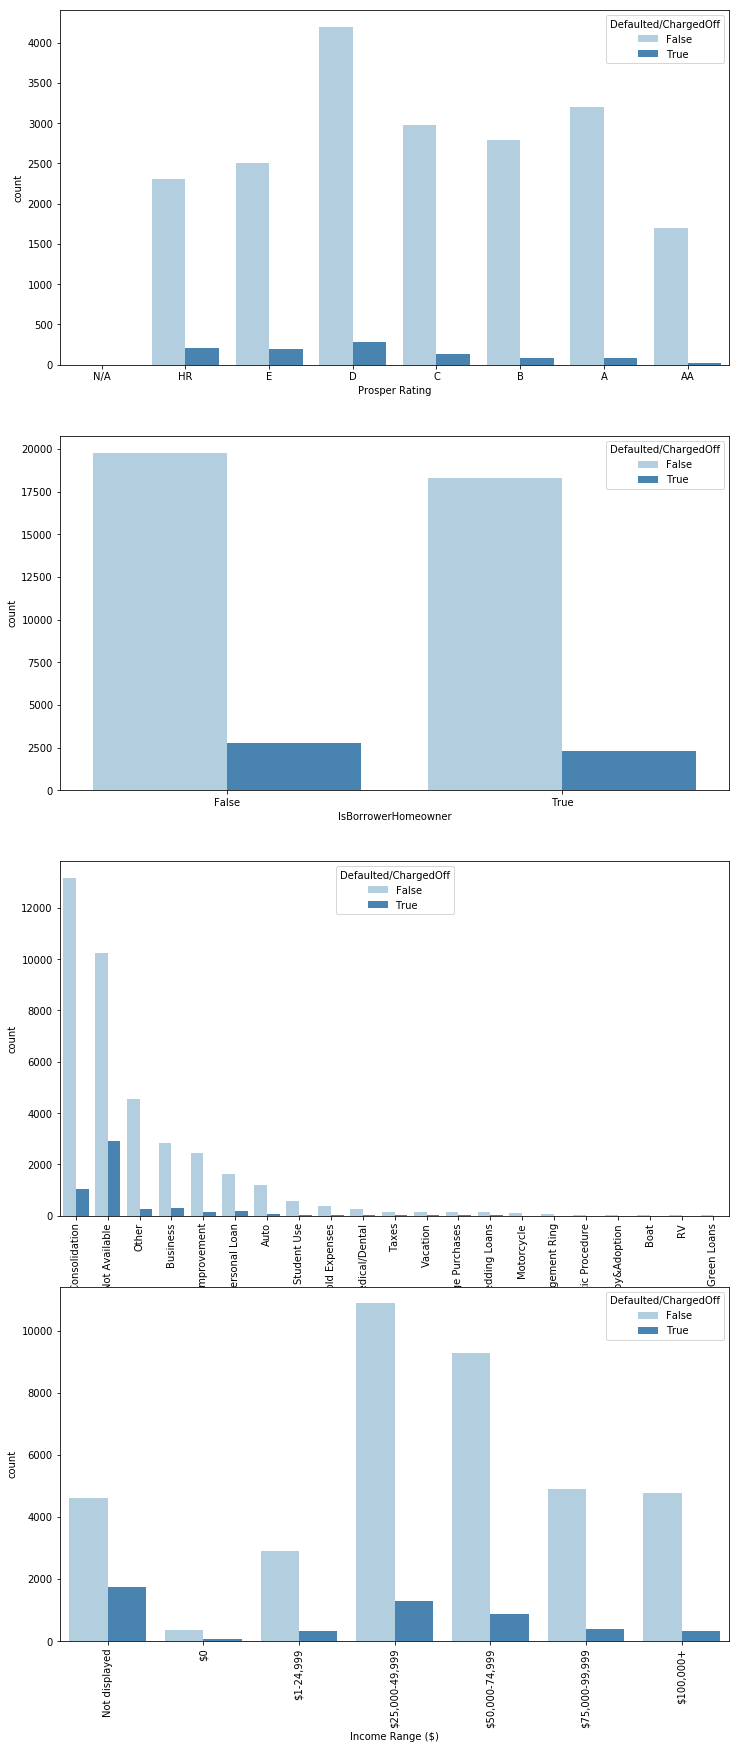

In [98]:
plt.figure(figsize = [12, 30])

# subplot 1: Prosper rating
plt.subplot(4, 1, 1)
sb.countplot(data = df_completed, x = 'ProsperRating(Alpha)',  hue = 'Defaulted/ChargedOff', palette = 'Blues')
plt.xlabel('Prosper Rating')

# subplot 2: Homeowner vs non-homeowner
ax = plt.subplot(4, 1, 2)
sb.countplot(data = df_completed, x = 'IsBorrowerHomeowner', hue = 'Defaulted/ChargedOff', palette = 'Blues')

# subplot 3: Listing Category
ax = plt.subplot(4, 1, 3)
sb.countplot(data = df_completed, x = 'ListingCategory', hue = 'Defaulted/ChargedOff', palette = 'Blues', order=df_completed['ListingCategory'].value_counts().index)
plt.xlabel('Listing Category')

plt.xticks(rotation = 90)

#subplot 4: Income Range
ax = plt.subplot(4, 1, 4)
sb.countplot(data = df_completed, x = 'IncomeRange', hue = 'Defaulted/ChargedOff', palette = 'Blues')
plt.xticks(rotation = 90)
plt.xlabel('Income Range ($)')
plt.show()



- In the top gragh, we can see that the lowest two Prosper rating categories also have the highest percentage of Defaulted or Charged Off loans. 

- Home ownership does not show any obvious relationship. 

- The most important thing that I take from these graphs comes from the results in the missing data categories in the Income Range and Listing Category graphs. It seems that missing data increases the probability of Defaults and Charge Offs. Both 'Not displayed' and 'Not Available' have the highest percentage of defaults than the other categories. 
 
  

#### Time and categorical variables

Below we can see time series data about Listing Category and Income Range.
When we compare unavailable data, it appears that the bank may have learned that it would be helpful if this data was collected. 

C:\Users\Summer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


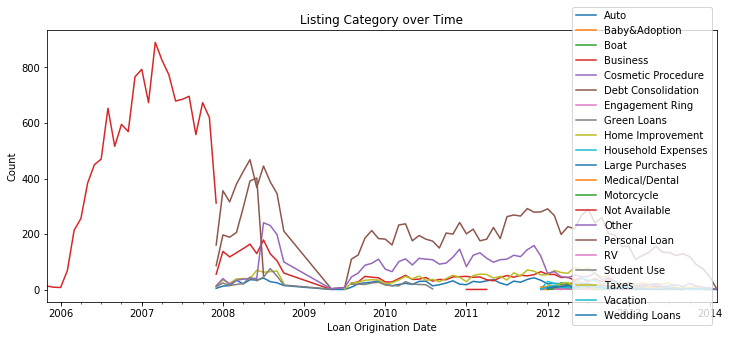

In [99]:
df_completed['mnth_yr'] = df_completed['LoanOriginationDate'].dt.to_period('M')

fig, ax = plt.subplots(figsize=(12,5))

df_completed.groupby(['mnth_yr','ListingCategory']).count()['ListingKey'].unstack().plot(ax = ax)
plt.title('Listing Category over Time')
plt.ylabel('Count')
plt.xlabel('Loan Origination Date')
plt.legend(loc = 'right')



This shows an important information. The provided variable description in Google Sheets did not inform us that categories only began to be distinguished after 2008. It also shows that there is missing data for this variable in part of 2009 and 2010. 

Text(0.5, 0, 'Loan Origination Date')

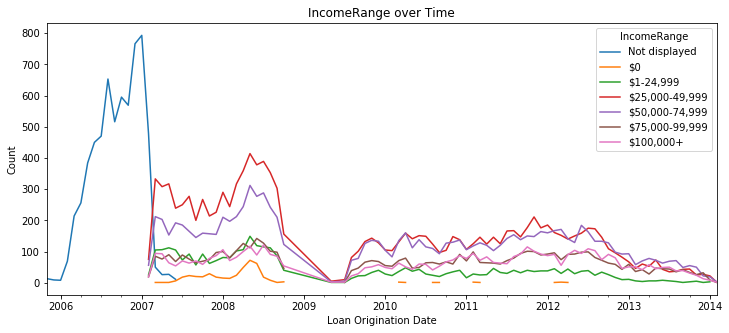

In [100]:
fig, ax = plt.subplots(figsize=(12,5))


df_completed.groupby(['mnth_yr','IncomeRange']).count()['ListingKey'].unstack().plot(ax = ax)
plt.title('IncomeRange over Time')
plt.ylabel('Count')
plt.xlabel('Loan Origination Date')

Similarly, Income ranges were not collected in the early loans either. 

We cannot know the reason for the lack of data, but it may be that the bank discovered that this data helped quantify risk more acurately, particularly because these unknown categories seem to be associated with defaults and chargeoffs. 

Text(0.5, 0, '')

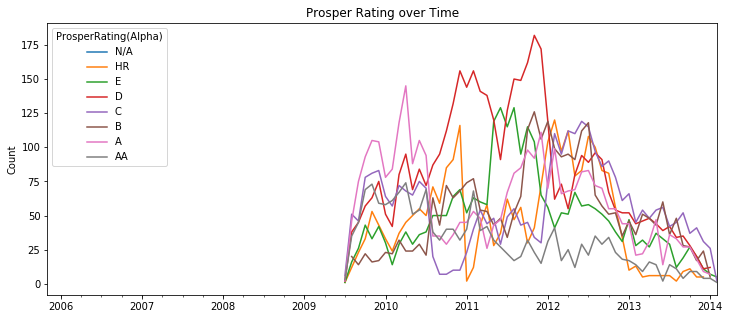

In [101]:
fig, ax = plt.subplots(figsize=(12,5))


df_completed.groupby(['mnth_yr','ProsperRating(Alpha)']).count()['ListingKey'].unstack().plot(ax = ax)
plt.title('Prosper Rating over Time')
plt.ylabel('Count')
plt.xlabel('')


Prosper Ratings were not collected until 2009

#### Defaults and Charge Offs over time

Text(0.5, 0, 'Loan Origination Date')

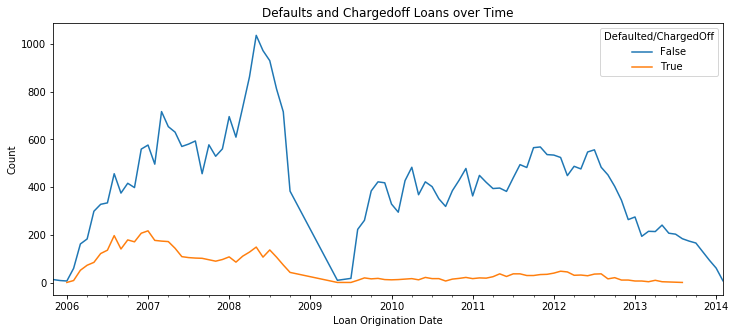

In [102]:
fig, ax = plt.subplots(figsize=(12,5))

df_completed.groupby(['mnth_yr','Defaulted/ChargedOff']).count()['ListingKey'].unstack().plot(ax = ax)
plt.title('Defaults and Chargedoff Loans over Time')
plt.ylabel('Count')
plt.xlabel('Loan Origination Date')

It seems to be that defaults and charge offs decreased after 2007 and further after the missing period in 2009. Perhaps better data collection was instrumental to this. Since 2009, defaults and charged off loans seem to stay close to 0. 

#### Distribution of Income Range vs. Prosper Rating
The following shows distribution of the borrowers characteristics. 

$25,000-49,999    12181
$50,000-74,999    10156
Not displayed      6357
$75,000-99,999     5289
$100,000+          5096
$1-24,999          3242
$0                  421
Name: IncomeRange, dtype: int64

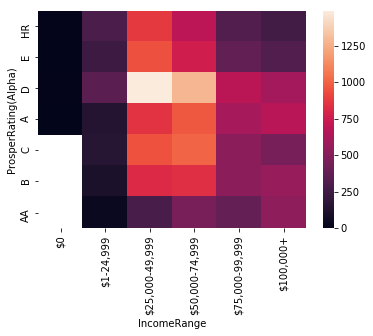

In [103]:
#heatmap of income range and Prosper Rating
ct_counts = df_completed.groupby(['IncomeRange', 'ProsperRating(Alpha)']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'ProsperRating(Alpha)', columns = 'IncomeRange', values = 'count')
sb.heatmap(ct_counts)
cbar = True
df_completed.IncomeRange.value_counts()

This is a two dimensional histogram of two variables. The highest proportion can be found among borrowers with low/middle incomves and Prosper ratings of D, which are on third from the bottom of the ranking. It shows that the highest frequency of borrowers have lower/mid level ratings, and lower incomes.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> It was difficult to find strong relationships between our variables of interest (Net Principal Loss and Defaulted/ChargedOff loans).  Because the relationships are weak, it means that the bank is effectively identifying risk and shaping loan conditions to avoid that high risk borrowers do not end up as a loss for the bank. The strongest relationship with loss was with debt to income ratio. It is possible that the back could use this information to better predict loss.

> The best relationship I could find with Defaults and Charged Off loans was with categories that were unidentified. This caused me the do a time series plot, and there I discovered that for a period of time, no data was beeing collected on Income Range and Listing Category. 

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> The time series plots revealed unexpected results. The bank has changed the way it collects data and this seems to have resulted in better performance. Defaults and charge offs have decreaced over time. 

## Multivariate Exploration


#### Net Principal Loss vs. numeric variables and Home Ownership
The below is a repitition of the bivariate plot above but with the inclusion of home ownership. 

Text(0.5, 1.0, 'Estimated Loss')

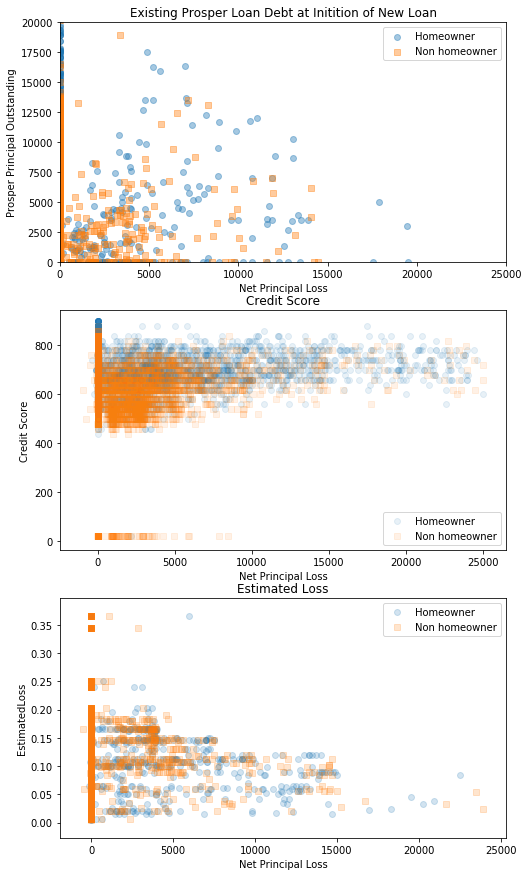

In [104]:
plt.figure(figsize = [8, 15])

plt.subplot(3, 1, 1)
cat_markers = [[True, 'o'],
               [False, 's']]

for cat, marker in cat_markers:
    df_cat = df_completed[df_completed['IsBorrowerHomeowner'] == cat]
    plt.scatter(data = df_cat, y = 'ProsperPrincipalOutstanding', x = 'LP_NetPrincipalLoss', marker = marker, alpha = 4/10)
plt.legend(['Homeowner','Non homeowner'])
plt.xlim([1,25000])
plt.ylim([1,20000])
plt.xlabel('Net Principal Loss')
plt.ylabel('Prosper Principal Outstanding')
plt.title('Existing Prosper Loan Debt at Initition of New Loan')


plt.subplot(3, 1, 2)

cat_markers = [[True, 'o'],
               [False, 's']]

for cat, marker in cat_markers:
    df_cat = df_completed[df_completed['IsBorrowerHomeowner'] == cat]
    plt.scatter(data = df_cat, y = 'CreditScoreRangeUpper', x = 'LP_NetPrincipalLoss', marker = marker, alpha = 1/10)
plt.legend(['Homeowner','Non homeowner'])
plt.ylabel('Credit Score')
plt.title('Credit Score')
plt.xlabel('Net Principal Loss')
plt.subplot(3, 1, 3)



cat_markers = [[True, 'o'],
               [False, 's']]

for cat, marker in cat_markers:
    df_cat = df_completed[df_completed['IsBorrowerHomeowner'] == cat]
    plt.scatter(data = df_cat, y = 'EstimatedLoss', x = 'LP_NetPrincipalLoss', marker = marker, alpha = 2/10)
plt.legend(['Homeowner','Non homeowner'])
plt.xlabel('Net Principal Loss')
plt.ylabel('EstimatedLoss')
plt.title('Estimated Loss')


The Credit Score graph in the middle shows the most obvious differentiation in home ownership. 
The loans with high levels of loss are biased toward higher credit scores, presumably because those with lower credit scores are limited in the size of their loans. Most of the low levels of loss are populated by the non-homeowners. The higher levels of loss are more likely to be homeowners. 

#### Time, Home Ownership and Loss


Text(0, 0.5, 'Net Principal Loss $')

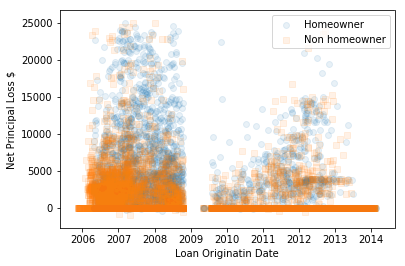

In [105]:
cat_markers = [[True, 'o'],
               [False, 's']]

for cat, marker in cat_markers:
    df_cat = df_completed[df_completed['IsBorrowerHomeowner'] == cat]
    plt.scatter(data = df_cat, x = 'LoanOriginationDate', y = 'LP_NetPrincipalLoss', marker = marker, alpha = 1/10)
plt.legend(['Homeowner','Non homeowner'])
plt.xlabel('Loan Originatin Date')
plt.ylabel('Net Principal Loss $')

Again, we discover something surprising. The period before the before the gap in data and the period after look very different. 
There is a high frequency of loans with small losses among borrowers who do not own homes. This is absent in the second time period where the distribution looks some what even. 

#### Loss and credit scores

Next we will look at the same relationship between Loss and credit scores, but it shows whether or not the loan was Defaulted or Charged Off instead of whether the borrower was a Home Owner.

Text(0.5, 0, 'Net Principal Loss $')

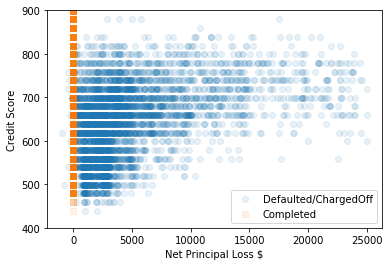

In [106]:
cat_markers = [[True, 'o'],
               [False, 's']]
for cat, marker in cat_markers:
    df_cat = df_completed[df_completed['Defaulted/ChargedOff'] == cat]
    plt.scatter(data = df_cat, y = 'CreditScoreRangeUpper', x = 'LP_NetPrincipalLoss', marker = marker, alpha = 1/10)
plt.legend(['Defaulted/ChargedOff','Completed'])
plt.ylabel('Credit Score')
plt.ylim([400,900])
plt.xlabel('Net Principal Loss $')

It is clear that Defaulted or Charged Off loans populate most of the loans with losses. This also helps give us confidence that our two variables of interest are consistent measures of poor performance.

#### Loss and Debt to Income Ratio by Prosper rating

In [107]:
def hist2dgrid(x, y, **kwargs):
    """ Quick hack for creating heat maps with seaborn's PairGrid. """
    palette = kwargs.pop('color')
    plt.hist2d(x, y, cmap = palette, cmin = 0.5)
    

C:\Users\Summer\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


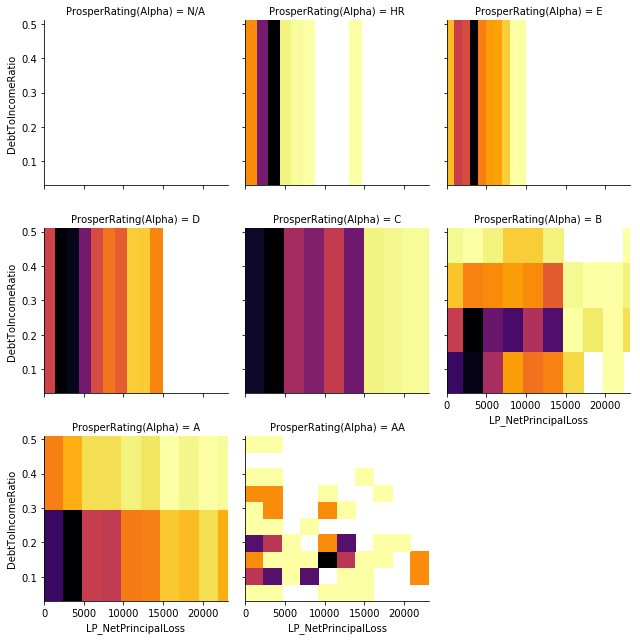

In [108]:
net_loss= df.query('(LP_NetPrincipalLoss != 0)')

g = sb.FacetGrid(data = net_loss, col = 'ProsperRating(Alpha)', col_wrap = 3, size = 3)
g.map(hist2dgrid, 'LP_NetPrincipalLoss', 'DebtToIncomeRatio', color = 'inferno_r' )


plt.show()

We can see here that right side of the graphs for the lower Prosper ratings are quite empty. Again, I presume this is because they are restricted as to the size of the loans that they may take out.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> The lender's efforts to limit risk become even more apparent. Most of the loans that have a high loss were seen from borrowers with low risk. Likely, because borrowers with high risk are given less freedom with their loans. 

### Were there any interesting or surprising interactions between features?

> Again, the change over time were surprising. The bank seems to have improved its ability to prevent loss and defaults over time. The dense aggregation of small losses among non-homeowning borrowers disappeared after 2008.

### Conclusions: 
> In general, the interections between my Loss and Defaults and the explanatory variables are not strong. I specilate that this is because the lender does well at using the information it gathers to prevent these relationships from being expressed in their loans. It also appears that the lender has become better at this over time. It has progressively increased data collection and decreased loss and loans that become defaulted and charged off. 